In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2


In [3]:
DATASET = "polyp"
BASE_DIR = f"/home/vblot/multiaccurate_cp/data/{DATASET}"


In [4]:
IMG_SIZE = 64


In [5]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [6]:
def load_data(pred_probas_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, labels


In [7]:
c_pp, c_l = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_LABELS)


209it [00:08, 14.93it/s]

In [ ]:
t_pp, t_l = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_LABELS)

546it [00:00, 945.81it/s] 


In [ ]:
all_pred_probas = np.concatenate([c_pp, t_pp])
all_labels = np.concatenate([c_l, t_l])

all_pred_probas.shape, all_labels.shape

((798, 64, 64), (798, 64, 64))

In [ ]:
ALPHA = .1

In [ ]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [29]:
recalls = []
precisions = []

# kf = KFold(n_splits=100, shuffle=True, random_state=42)
for _ in tqdm(range(100)):
    cal_inx = np.random.choice(range(len(all_pred_probas)), len(all_pred_probas) // 2 , replace=False)
    test_inx = np.array([i for i in range(len(all_pred_probas)) if i not in cal_inx])
    temp_cal_pred_probas = all_pred_probas[cal_inx]
    temp_cal_labels = all_labels[cal_inx]
    temp_test_pred_probas = all_pred_probas[test_inx]
    temp_test_labels = all_labels[test_inx]

    n = len(temp_cal_pred_probas)
    mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
    for i in range(len(temp_cal_labels)):
        X, y = temp_cal_pred_probas[i], temp_cal_labels[i]
        mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])

    _, _ = mapie_crc.predict(temp_test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
    th_crc = mapie_crc.lambdas_star

    y_pred_test_th = (temp_test_pred_probas >= th_crc).astype(int)
    recall_test = (y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))
    precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
    recalls.append(np.nanmean(recall_test))
    precisions.append(np.nanmean(precision_test))
    # print(np.nanmean(recall_test))

    


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1494523/2455691256.py:24: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
  1%|          | 1/100 [00:00<00:35,  2.78it/s]/tmp/ipykernel_1494523/2455691256.py:24: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
  2%|▏         | 2/100 [00:00<00:32,  3.00it/s]/tmp/ipykernel_1494523/2455691256.py:24: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
  3%|▎         | 3/100 [00:01<00:32,  2.99it/s]/tmp/ipykernel_1494523/2455691256.py:24: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * temp_test_lab

(array([ 2.,  0.,  6., 12., 10., 20., 15., 23.,  8.,  4.]),
 array([0.73663917, 0.74833149, 0.76002381, 0.77171614, 0.78340846,
        0.79510078, 0.8067931 , 0.81848543, 0.83017775, 0.84187007,
        0.8535624 ]),
 <BarContainer object of 10 artists>)

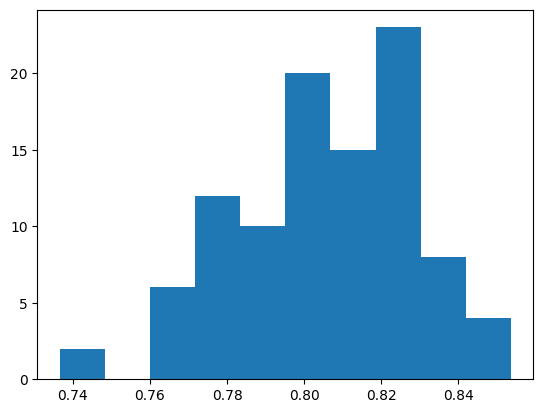

In [30]:
plt.hist(recalls)

In [31]:
np.mean(recalls)

0.804631467724038

(array([ 3.,  6., 11., 20., 17., 20.,  8.,  9.,  4.,  2.]),
 array([0.72358821, 0.7386689 , 0.75374958, 0.76883026, 0.78391094,
        0.79899163, 0.81407231, 0.82915299, 0.84423368, 0.85931436,
        0.87439504]),
 <BarContainer object of 10 artists>)

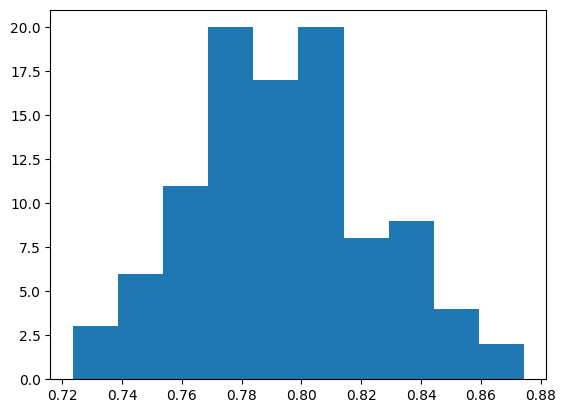

In [32]:
plt.hist(precisions)

In [33]:
np.unique(ths)

NameError: name 'ths' is not defined

In [ ]:
ths

array([[[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0